First, I should module-ize the definition of the LST grid, and maybe save it out somewhere as additional information about the LST-"sliced" data, since it's a global thing, not a specific to a single file.

I'm also not 100% sure that using the definition of LST in the files, we actually get the same sky above us night-to-night.  That is, for the definition of local sidereal time, is "the" RA that's overhead the RA current epoch?  If so, that will move from night to night.  I think you want function that will give you, for a grid of ICRS coordinates, what time those coordinates appear overhead on a given date.  I'm _sure_ there's not an astropy function for that, unless it is `sidereal_time`.

In [25]:
from astropy import units as u
import numpy as np
from glob import glob
import os
from pyuvdata import UVData
from astropy.coordinates import Angle
from astropy.io import fits
from tqdm.notebook import tqdm
from casatasks import importuvfits, exportfits, tclean, importfits
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Set up LST grid; in radians
# A trifle worried about numerical precision, but let's plunge ahead

# Files will be this long
lst_bin_size = 6.*u.min
n_lst_bins = int((24.*u.hr/lst_bin_size).to(u.dimensionless_unscaled).value)
lst_edges = np.linspace(0, 2.*np.pi, n_lst_bins+1, endpoint=True)
lst_start = lst_edges[0:-1]
lst_end = lst_edges[1:]
lst_mid = (lst_start + lst_end)/2.

assert len(lst_start) == n_lst_bins
assert len(lst_end) == n_lst_bins
assert np.isclose((lst_end-lst_start)*24.*60./(2.*np.pi), lst_bin_size.value).sum() == n_lst_bins

# Need to specify the time sampling within a "bin"
lst_time_sample = 10*u.s # This is actually every 10 sidereal seconds
n_samples = int((lst_bin_size/lst_time_sample).to(u.dimensionless_unscaled).value)
lst_sampling = ((np.arange(n_samples)*lst_time_sample)/(24*u.hr)).to(u.dimensionless_unscaled).value*2.*np.pi

In [3]:
def jd_at_lst(uvdata, lst0):
    """ Given a UVData object, find the JD corresponding to the requested LST.  
    Uses simple linear interpolation. """
    jd = np.unique(uvdata.time_array)
    lst = np.unique(uvdata.lst_array)
    
    return np.interp(lst0, lst, jd)

In [10]:
#jds = [str(jd) for jd in np.arange(2457548, 2457555)]
lstpath = '/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/LSTSlice/'

In [11]:
lstfiles = np.sort(glob(lstpath+'Simulation/lst*.uvh5'))
#lstfiles

In [74]:
for lstfile in tqdm(lstfiles):
        
        dirname, filename = os.path.split(lstfile)
        basename, ext = os.path.splitext(filename)
        basename, ext = os.path.splitext(basename)
        basename += '.phased'
        
        lst_start_str = basename.split('.')[2]
        
        print(lst_start_str)
        
        uvd = UVData()
        uvd.read(lstfile)
        
        lst0 = uvd.lst_array.min()
        #lst0hr = np.round(lst0*24/(2.*np.pi),decimals=2)
        lst_bin = np.argmin(np.abs(lst0-lst_start))
        #print(lst0, lst_start[lst_bin], lst0-lst_start[lst_bin], lst0hr)
        
        #lst0hr = Angle(lst_start_str).hour
        
        jd_phase = jd_at_lst(uvd, lst_mid[lst_bin])
        print('Phasing',filename,'to',jd_phase)
        uvd.phase_to_time(jd_phase)
        
            
        uvfitsfile = basename+'.uvfits'
        msfile = basename+'.ms'
        imagedir = os.path.join(dirname,basename+'.image')
        os.system('mkdir '+imagedir)
        print('Writing',uvfitsfile)
        # Write the phased data
        uvd.write_uvfits(os.path.join(dirname,uvfitsfile), spoof_nonessential=True)
        # Convert to a measurement set
        vis = os.path.join(dirname, msfile)
        importuvfits(fitsfile=os.path.join(dirname,uvfitsfile),vis=vis)
        # Image
        #grab ra and dec from uvfits file
        #hdu = fits.open(os.path.join(dirname,uvfitsfile))
        #ra = hdu[0].header['CRVAL6']
        #dec = hdu[0].header['CRVAL7']
        # I want the thing to be phased to this RA/Dec J2000, but it's actually not, dammit
        lat, long, alt = uvd.telescope_location_lat_lon_alt_degrees
        ra = Angle(lst_mid[lst_bin]*u.radian).to(u.degree).value
        dec = lat
        print('{:.8f} {:.8f}'.format(ra, dec))
        print('Difference between phase center and J2000 {:.8f}'.format(uvd.phase_center_ra_degrees - ra))
        #tclean to make dirty image
        tclean(vis=vis,
               imagename=os.path.join(imagedir,basename),
               imsize = [512,512], cell=['500 arcsec'], specmode='mfs', spw='0:150~900', 
               stokes='IQUV',interactive=False, pblimit=-1, gridder='widefield',
               phasecenter='J2000 %sdeg %sdeg' % (ra, dec))
        # This will someday lead to sadness
        imagefiles = glob(imagedir+'/*'+lst_start_str+'*')
        for imagefile in imagefiles:
            exportfits(imagename=imagefile, fitsimage=imagefile+'.fits', overwrite=True)

  0%|          | 0/116 [00:00<?, ?it/s]

11h00m00s
Phasing lst.2457756.11h00m00s.11h05m50s.uvcRP.drift.uvh5 to 2457755.617725675
Writing lst.2457756.11h00m00s.11h05m50s.uvcRP.phased.uvfits
165.75000000 -30.72152778
Difference between phase center and J2000 -0.20683615
11h06m00s
Phasing lst.2457756.11h06m00s.11h11m50s.uvcRP.drift.uvh5 to 2457755.621880965
Writing lst.2457756.11h06m00s.11h11m50s.uvcRP.phased.uvfits
167.25000000 -30.72152778
Difference between phase center and J2000 -0.20810338
11h12m00s
Phasing lst.2457756.11h12m00s.11h17m50s.uvcRP.drift.uvh5 to 2457755.6260362547
Writing lst.2457756.11h12m00s.11h17m50s.uvcRP.phased.uvfits
168.75000000 -30.72152778
Difference between phase center and J2000 -0.20937624
11h18m00s
Phasing lst.2457756.11h18m00s.11h23m50s.uvcRP.drift.uvh5 to 2457755.6301915445
Writing lst.2457756.11h18m00s.11h23m50s.uvcRP.phased.uvfits
170.25000000 -30.72152778
Difference between phase center and J2000 -0.21065386
11h24m00s
Phasing lst.2457756.11h24m00s.11h29m50s.uvcRP.drift.uvh5 to 2457755.63434683

14h36m00s
Phasing lst.2457756.14h36m00s.14h41m50s.uvcRP.drift.uvh5 to 2457755.767316112
Writing lst.2457756.14h36m00s.14h41m50s.uvcRP.phased.uvfits
219.75000000 -30.72152778
Difference between phase center and J2000 -0.24984184
14h42m00s
Phasing lst.2457756.14h42m00s.14h47m50s.uvcRP.drift.uvh5 to 2457755.7714714017
Writing lst.2457756.14h42m00s.14h47m50s.uvcRP.phased.uvfits
221.25000000 -30.72152778
Difference between phase center and J2000 -0.25077690
14h48m00s
Phasing lst.2457756.14h48m00s.14h53m50s.uvcRP.drift.uvh5 to 2457755.7756266915
Writing lst.2457756.14h48m00s.14h53m50s.uvcRP.phased.uvfits
222.75000000 -30.72152778
Difference between phase center and J2000 -0.25168847
14h54m00s
Phasing lst.2457756.14h54m00s.14h59m50s.uvcRP.drift.uvh5 to 2457755.7797819814
Writing lst.2457756.14h54m00s.14h59m50s.uvcRP.phased.uvfits
224.25000000 -30.72152778
Difference between phase center and J2000 -0.25257595
15h00m00s
Phasing lst.2457756.15h00m00s.15h05m50s.uvcRP.drift.uvh5 to 2457755.7839372

18h12m00s
Phasing lst.2457756.18h12m00s.18h17m50s.uvcRP.drift.uvh5 to 2457755.916906549
Writing lst.2457756.18h12m00s.18h17m50s.uvcRP.phased.uvfits
273.75000000 -30.72152778
Difference between phase center and J2000 -0.26533513
18h18m00s
Phasing lst.2457756.18h18m00s.18h23m50s.uvcRP.drift.uvh5 to 2457755.921061839
Writing lst.2457756.18h18m00s.18h23m50s.uvcRP.phased.uvfits
275.25000000 -30.72152778
Difference between phase center and J2000 -0.26516719
18h24m00s
Phasing lst.2457756.18h24m00s.18h29m50s.uvcRP.drift.uvh5 to 2457755.925217129
Writing lst.2457756.18h24m00s.18h29m50s.uvcRP.phased.uvfits
276.75000000 -30.72152778
Difference between phase center and J2000 -0.26496613
18h30m00s
Phasing lst.2457756.18h30m00s.18h35m50s.uvcRP.drift.uvh5 to 2457755.929372419
Writing lst.2457756.18h30m00s.18h35m50s.uvcRP.phased.uvfits
278.25000000 -30.72152778
Difference between phase center and J2000 -0.26473210
18h36m00s
Phasing lst.2457756.18h36m00s.18h41m50s.uvcRP.drift.uvh5 to 2457755.933527709


21h48m00s
Phasing lst.2457756.21h48m00s.21h53m50s.uvcRP.drift.uvh5 to 2457756.066496987
Writing lst.2457756.21h48m00s.21h53m50s.uvcRP.phased.uvfits
327.75000000 -30.72152778
Difference between phase center and J2000 -0.24042541
21h54m00s
Phasing lst.2457756.21h54m00s.21h59m50s.uvcRP.drift.uvh5 to 2457756.070652277
Writing lst.2457756.21h54m00s.21h59m50s.uvcRP.phased.uvfits
329.25000000 -30.72152778
Difference between phase center and J2000 -0.23928708
22h00m00s
Phasing lst.2457756.22h00m00s.22h05m50s.uvcRP.drift.uvh5 to 2457756.074807567
Writing lst.2457756.22h00m00s.22h05m50s.uvcRP.phased.uvfits
330.75000000 -30.72152778
Difference between phase center and J2000 -0.23813310
22h06m00s
Phasing lst.2457756.22h06m00s.22h11m50s.uvcRP.drift.uvh5 to 2457756.078962857
Writing lst.2457756.22h06m00s.22h11m50s.uvcRP.phased.uvfits
332.25000000 -30.72152778
Difference between phase center and J2000 -0.23696410
22h12m00s
Phasing lst.2457756.22h12m00s.22h17m50s.uvcRP.drift.uvh5 to 2457756.0831181468

<IPython.core.display.Javascript object>


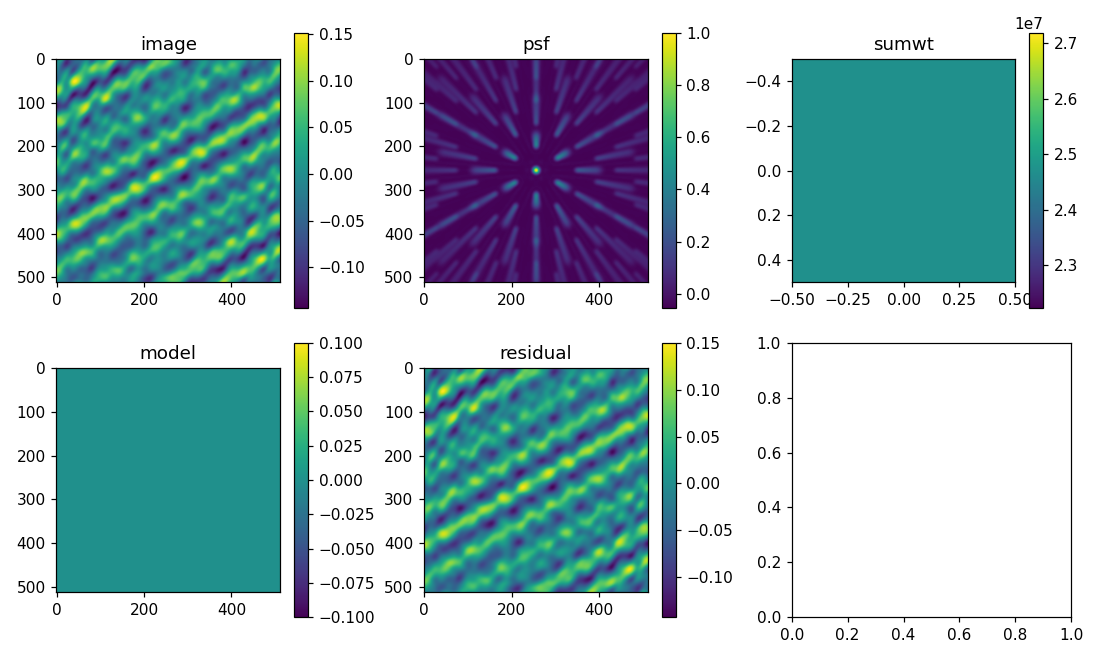

In [41]:
ff, aa = plt.subplots(2,3, figsize=(10,6))
for ii, name in enumerate(imagefiles):
    xx,yy = int(ii/3),ii%3
    
    dirname, filename = os.path.split(name)
    basename, ext = os.path.splitext(filename)
    
    im = aa[xx,yy].imshow(fits.getdata(name+'.fits')[3,0,:,:])
    plt.colorbar(im, ax=aa[xx,yy])
    aa[xx,yy].set_title(ext[1:])
plt.tight_layout()